<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/ESR/lorentzian/ESR%20Lorentzian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESR part B - relaxation time estimation with Lorentzian fit

Evgeny Kolonsky 2025

v.0.1.1

In [2]:
! pip install uncertainties

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.8 MB/s eta 0:00:00


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import linregress, chi2
from uncertainties import ufloat
from uncertainties.umath import *
import scipy.constants as const # Physical and mathematical constants and units.
from scipy.optimize import curve_fit


In [4]:
R = 0.82 # Om The resistor on which we measure the voltage
P1=[0, 98.6e6] # calibration data point reading - > frequency Hz
P2=[13,  98.3e6] # calibration data point
scale = (P2[0]-P1[0]) / (P2[1]-P1[1])

reading = 10 # on the variator scale 0.. 100

# estimated error in determining resonance frequency
nuRF_err_rel = 0.10 # let's have 10 percent uncertainty in determining resonanse frequency

# frequency with resonanse
nuRF_nominal = P1[1] + reading * scale # Hz
nu_err =nuRF_nominal * nuRF_err_rel # estimated error in resonanse freq
nuRF = ufloat(nuRF_nominal, nu_err)
print(f'resonanse frequency {nuRF/1e6} MHz')

resonanse frequency 99+/-10 MHz


# 1 kHz experiment

Wavegen = 1Khz, amplitude 5 Vpp

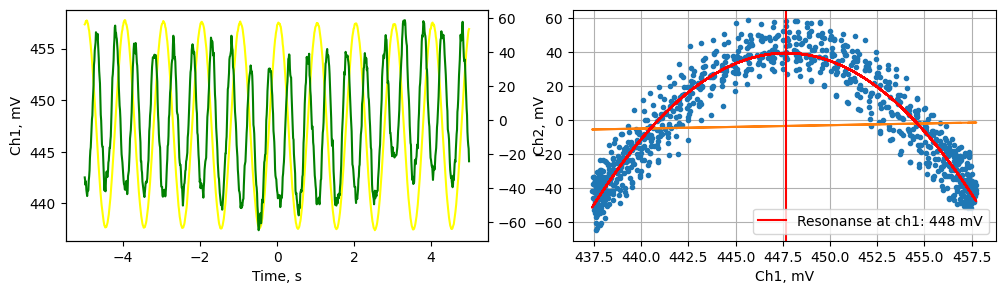

In [5]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab4/refs/heads/main/ESR/lorentzian/'
current = 535
filename = f'{url}{current}.csv'

t, ch1, ch2 = np.genfromtxt(filename, skip_header=46, delimiter=',',
                     usecols=[1,2,3], unpack=True)
ch1 *=1e3 # mV
ch2 *=1e3 # mV
t *=1e3   # ms

fig, ax = plt.subplots(1,2, figsize=(12, 3))
ax0 = ax[0].twinx()
ax[0].plot(t, ch1, color='yellow')
ax0.plot(t, ch2, color='green')
ax[0].set_xlabel('Time, s')
ax[0].set_ylabel('Ch1, mV')
ax0.set_ylabel('Ch2, mV')

ax[1].plot(ch1, ch2,'.')
ax[1].grid()
fit = linregress(ch1, ch2)
ax[1].plot(ch1, fit.slope * ch1 + fit.intercept)
ax[1].set_xlabel('Ch1, mV')
#ax[1].set_ylabel('Ch2, mV')

def parabola(x, a, b, c):
  return a * x**2 + b * x + c

popt, pcov = curve_fit(parabola, ch1, ch2)
a, b, c = popt
v_res = - b /2 /a
ax[1].plot(ch1, parabola(ch1, *popt), color='red', label=f'Resonanse at ch1: {v_res:.0f} mV')
ax[1].axvline(v_res, color='red')
ax[1].legend()

v_res /= 1e3 # mV -> V

499: ch1:417 mV slope: 2.141+/-0.035
508: ch1:425 mV slope: 4.72+/-0.05
518: ch1:434 mV slope: 8.88+/-0.06
528: ch1:442 mV slope: 8.01+/-0.10
530: ch1:443 mV slope: 6.18+/-0.11
534: ch1:446 mV slope: 2.24+/-0.14
535: ch1:448 mV slope: 0.20+/-0.15
539: ch1:451 mV slope: -4.23+/-0.13
543: ch1:454 mV slope: -7.55+/-0.09
548: ch1:458 mV slope: -9.65+/-0.05
559: ch1:467 mV slope: -6.21+/-0.05
569: ch1:476 mV slope: -2.70+/-0.04
578: ch1:484 mV slope: -1.267+/-0.033


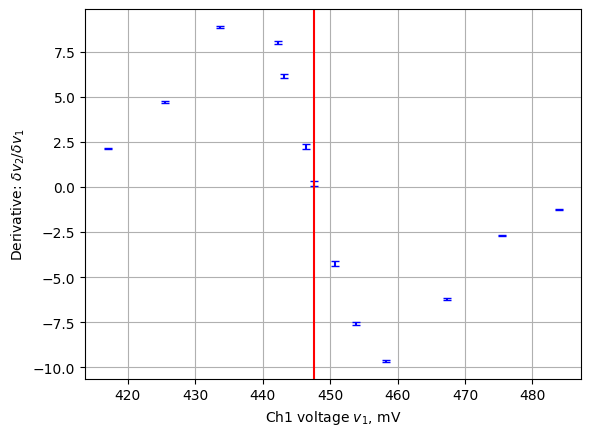

In [6]:
v_arr = []
d_arr = []
d_err = []
for current in [499, 508, 518, 528, 530, 534, 535, 539, 543, 548, 559, 569, 578]:
    filename = f'{url}{current}.csv'
    t, ch1, ch2 = np.genfromtxt(filename, skip_header=46, delimiter=',',
                         usecols=[1,2,3], unpack=True)
    #ch1 *=1e3 # mV
    #ch2 *=1e3 # mV
    #t *=1e3   # ms
    fit = linregress(ch1, ch2)
    deriv = fit.slope
    deriv_err = fit.stderr
    d = ufloat(deriv, deriv_err)
    v_arr.append(np.mean(ch1))
    d_arr.append(fit.slope)
    d_err.append(fit.stderr)

    print(f'{current}: ch1:{v_arr[-1]*1e3:.0f} mV slope: {ufloat(fit.slope, fit.stderr)}')

v_arr = np.array(v_arr)
d_arr = np.array(d_arr)
d_err = np.array(d_err)


plt.errorbar(v_arr*1e3, d_arr, d_err,  capsize=3, fmt='none', color='blue')
plt.axvline(v_res*1e3, color='red')
plt.xlabel(r'Ch1 voltage $v_1$, mV')
plt.ylabel(r'Derivative: $\delta v_2 / \delta v_1$')
plt.grid()

Lorentzian (here and below amplitude scaling constants are ommited for simplicity)
$$
L(x) = \frac{\gamma}{(x-1)^2 + \gamma^2}
\tag{1}
$$

Lorentzian first dirivative
$$
L'(x) = \frac{(x-1) \gamma}{[ (x-1)^2 + \gamma^2]^2}.
\tag{2}
$$
Lorentzian second derivative
$$
L''(x) = \gamma \frac{3(x-1)^2 - \gamma^2}{[ (x-1)^2 + \gamma^2]^3}.
\tag{3}
$$
Second derivative equals to zero at inflection points.

Parameter $\gamma$ can be found by fittig first derivative of the lorentzian function $L'(x)$ with parameter $\gamma$ (eq.2).

Alternatively,  noting that at inflection points the first derivative of Lorentian $L'(x)$ have extremums and the second derivative $L''(x)$ equals to  zero,  parameter $\gamma$ can be taken from distance $\Delta$ between inflection points and center point $x=1$:
$$
\Delta  = \frac{\gamma}{\sqrt{3}} .
\tag{4}
$$

Fitted Parameter gamma with relative error 3%:
gamma: 0.0374+/-0.0011


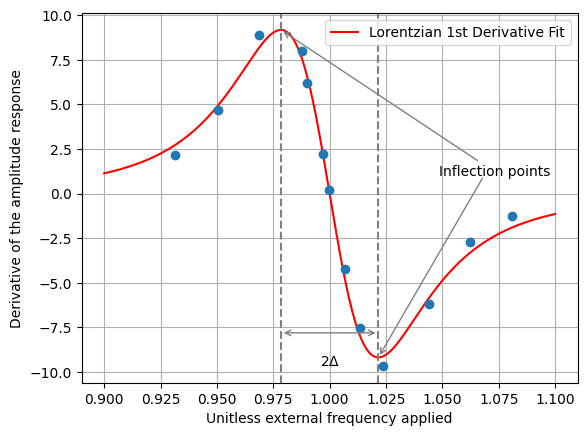

In [13]:
# prompt: curve fit to lorentzian derivative


def lorentzian_derivative(x, A,  gamma):
  """Derivative of a Lorentzian function."""
  return A * ((x - 1) * gamma) / ((x - 1)**2 + gamma**2)**2

# from voltage to unitless frequency

omega = v_arr / v_res

# Fit the derivative data
popt, pcov = curve_fit(lorentzian_derivative, omega, d_arr)


err = np.sqrt(np.diag(pcov))

# Extract fitted parameters
gamma_fit = popt[1]
gamma_err = err[1]

gamma = ufloat(gamma_fit, gamma_err)

print(f"Fitted Parameter gamma with relative error {gamma.s / gamma.n*100:.0f}%:")
print(f"gamma: {gamma}")

# Plot the fitted curve
x = np.linspace(0.9,1.1, 500)

y_fit = lorentzian_derivative(x, *popt)

plt.plot(x, y_fit, color='red', label=f'Lorentzian 1st Derivative Fit')
plt.legend(loc='upper right')
plt.plot(omega, d_arr, 'o', label='Data Points')
plt.xlabel('Unitless external frequency applied')
plt.ylabel('Derivative of the amplitude response')
# Calculate positions of the dashed lines (inflection points)
inflection_point1 = 1 - gamma_fit / np.sqrt(3)
inflection_point2 = 1 + gamma_fit / np.sqrt(3)

# Annotate inflection points
plt.axvline(inflection_point1, ls='--', color='gray')
yip1 = lorentzian_derivative(inflection_point1, *popt)
yip2 = lorentzian_derivative(inflection_point2, *popt)
plt.annotate('Inflection points', xy=(inflection_point1, yip1), xytext=(inflection_point1+0.070, 1),
             arrowprops=dict(arrowstyle='->', color='gray'))
plt.annotate('', xy=(inflection_point2, yip2), xytext=(inflection_point1+0.090, 1),
             arrowprops=dict(arrowstyle='->', color='gray'))

plt.axvline(inflection_point2, ls='--', color='gray')

# Add annotation for the distance between dashed lines
arrow_y = np.min(d_arr) + 0.1 * (np.max(d_arr) - np.min(d_arr)) # Position the arrow below the data
plt.annotate('', xy=(inflection_point2, arrow_y), xytext=(inflection_point1, arrow_y),
             arrowprops=dict(arrowstyle='<->', color='gray'))
plt.text((inflection_point1 + inflection_point2) / 2, arrow_y - 0.1 * (np.max(d_arr) - np.min(d_arr)),
         r'$2\Delta$', horizontalalignment='center')

plt.grid()
plt.show()



In [20]:
residuals = d_arr - lorentzian_derivative(omega, *popt)
chi2_observed = np.sum(residuals**2 / d_err)
DOF = len(d_arr) -1
print(f'Chi2 observed {chi2_observed:.0f} for {DOF=}')
p_value = chi2.sf(chi2_observed, DOF)
print(f'Confidence of fit: {p_value:.2f}')

Chi2 observed 59 for DOF=12
Confidence of fit: 0.00


Relaxation time
$$
T_2 = \frac{1}{\omega_{res}\gamma} =  \frac{1}{2\pi \nu_{res} \gamma}
\tag{5}
$$

In [8]:
T2 = 1/2/np.pi / nuRF / gamma
print(f'Relaxation time: {T2*1e9} ns')

Relaxation time: 43+/-5 ns


**Reference values**

[scispace](https://scispace.com/search?q=ESR+DPPH+relaxation+time+T2+typical+value):

The typical value of the electron spin relaxation time T2 for DPPH (Diphenylpicrylhydrazyl) is generally in the range of 3 x 10^-8 seconds to 10^-7 seconds. This range is consistent across various studies that have measured T2 in different environments, including crystalline and liquid solutions. The relaxation behavior is influenced by interactions between electron spins and their local environments, which can vary based on the molecular structure and the medium in which the radicals are dissolved.



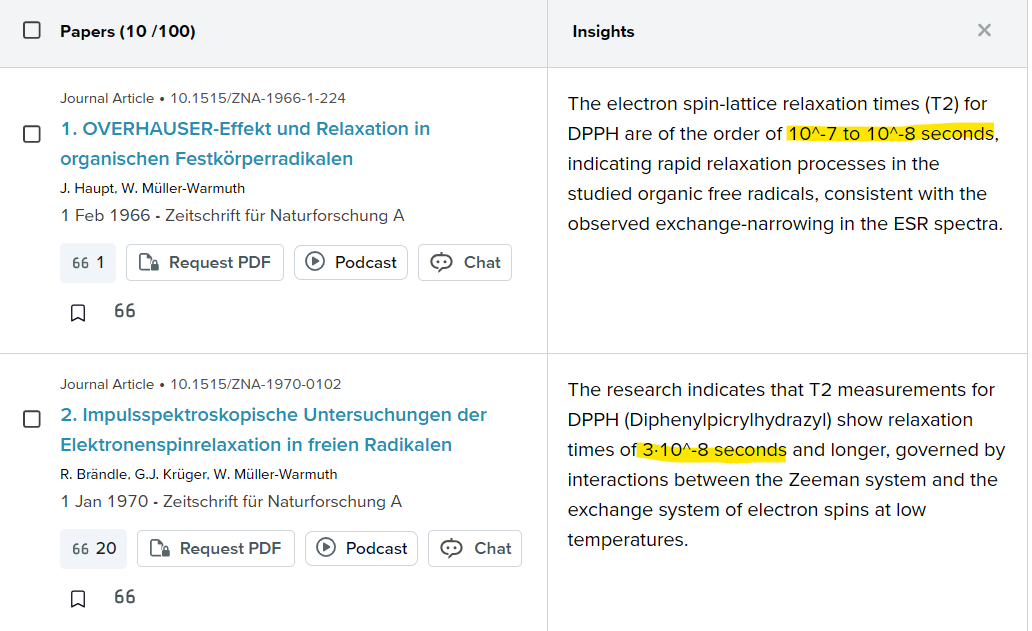